In [1]:
import sys; sys.path.insert(0, '../')
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [44]:
precincts = gpd.read_file("../data/nyc_precincts/Police Precincts.geojson")
precincts['precinct'] = precincts['precinct'].astype(int)
tickets = pd.read_csv("../data/nyc_parking/Aggregated_Parking_Violations_-_Fiscal_Year_2016.csv", index_col=0)
# Due to an error on my part, the result is not quite grouped correctly. The following code bit fixes the issue.
tickets = tickets.groupby(['Precinct', 'State Name'])[['Count']].sum().reset_index()
tickets = tickets[tickets['Precinct'].isin(precincts['precinct'].values)]
tickets['Precinct'] = tickets['Precinct'].astype(int)
boroughs = gpd.read_file("../data/nyc_boroughs/boroughs.geojson")

In [72]:
state_names = np.unique(tickets['State Name'].values)
precinct_ticket_totals = tickets.groupby('Precinct').sum()
state_ticket_totals = tickets.groupby('State Name').sum()
precincts = precincts.set_index('precinct')

In [64]:
def tickets_by_precinct(state):
    """
    Returns data with the percentage of tickets issued in the given census tract out of all tickets issued to that
    *precinct*
    """
    state_tickets = tickets[tickets['State Name'] == state].set_index('Precinct')
    
    def get_precinct_ticket_percentage(srs):
        precinct = srs.name
        state_count = srs['Count']
        precinct_count = precinct_ticket_totals.loc[precinct]
        return state_count / precinct_count
        # all_tickets = int(precinct_ticket_totals.loc[precinct]['Count'])
        # return state_tickets[state_tickets['Precinct'] == precinct].set_index('Precinct')['Count'].iloc[0] / all_tickets
    
    precinct_ticket_percentages = state_tickets.apply(get_precinct_ticket_percentage, axis='columns')
        
    def get_geom(precinct_num):
        try:
            return precincts.loc[precinct_num].geometry
        except:
            print("WARNING: Does the {0}th precinct exist?".format(precinct_num))
    
    geom = precinct_ticket_percentages.index.map(get_geom)
    geo_data = gpd.GeoDataFrame(data=precinct_ticket_percentages, geometry=geom)
    return geo_data

In [118]:
state_ticket_totals.loc['Puerto Rico']

Precinct    3788
Count        223
Name: Puerto Rico, dtype: int64

In [140]:
state_ticket_totals.sort_values(by='Count', ascending=False)

,Precinct,Count
State Name,,
New York,4876,6679268
New Jersey,4876,854647
Pennsylvania,4876,215065
Connecticut,4876,126661
Florida,4876,111583
Massachusetts,4876,88367
Indiana,4876,79507
Virginia,4876,62155
Maryland,4876,50196


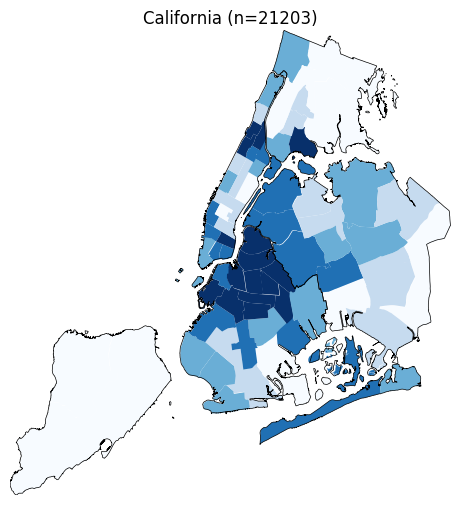

In [117]:
ax = gplt.choropleth(tickets_by_precinct('California'), projection=ccrs.AlbersEqualArea(), cmap='Blues',
                     linewidth=0.0)
gplt.polyplot(boroughs, projection=ccrs.AlbersEqualArea(), edgecolor='black', linewidth=0.5, ax=ax)
plt.title("California (n=21203)")

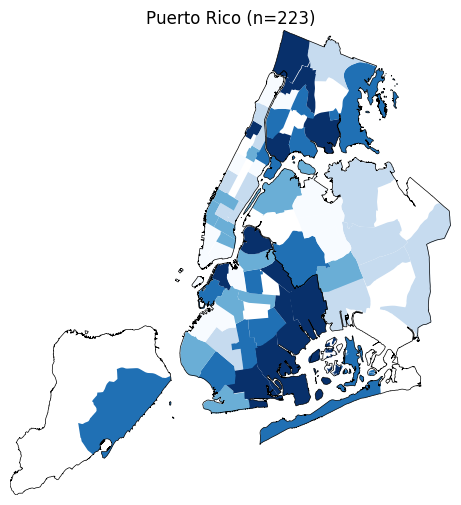

In [119]:
ax = gplt.choropleth(tickets_by_precinct('Puerto Rico'), projection=ccrs.AlbersEqualArea(), cmap='Blues',
                     linewidth=0.0)
gplt.polyplot(boroughs, projection=ccrs.AlbersEqualArea(), edgecolor='black', linewidth=0.5, ax=ax)
plt.title("Puerto Rico (n=223)")

In [147]:
def plot_state_to_ax(state, ax):
    n = state_ticket_totals.loc[state]['Count']
    gplt.choropleth(tickets_by_precinct(state), projection=ccrs.AlbersEqualArea(), cmap='Blues',
                    linewidth=0.0, ax=ax)
    gplt.polyplot(boroughs, projection=ccrs.AlbersEqualArea(), edgecolor='black', linewidth=0.5, ax=ax)
    ax.set_title("{0} (n={1})".format(state, n))

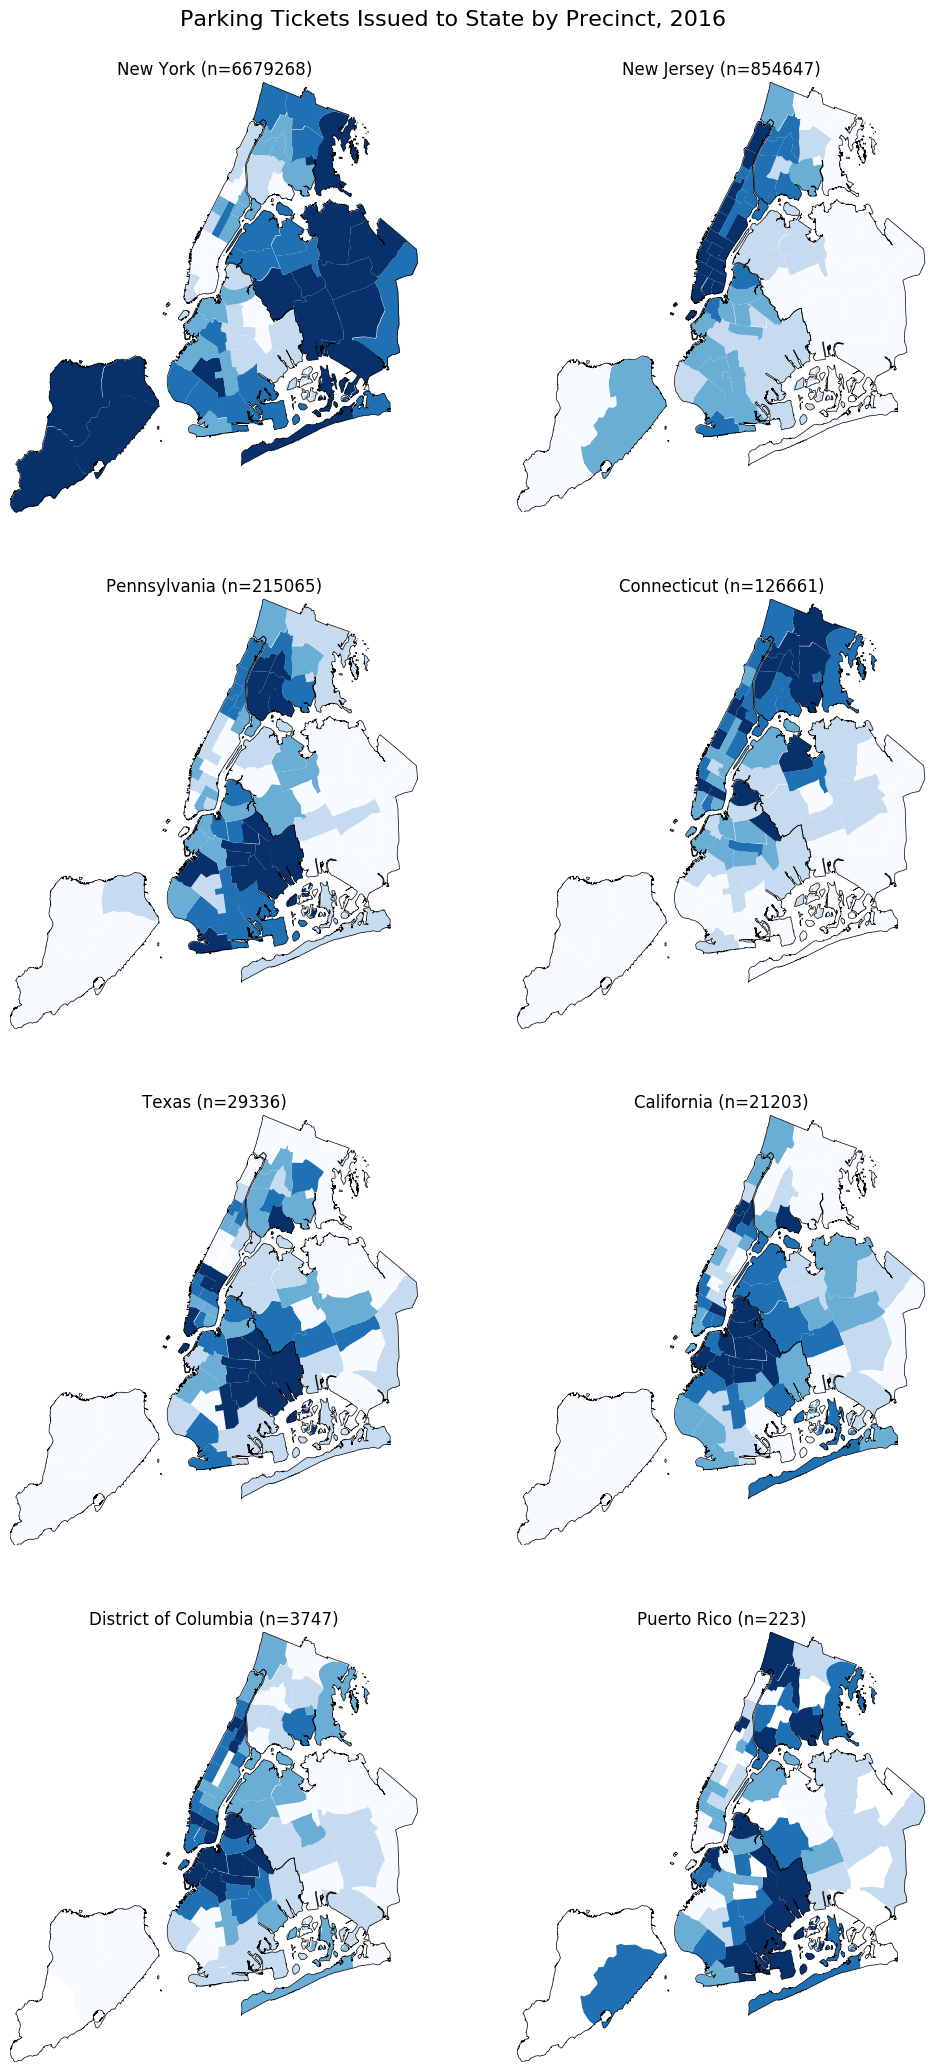

In [158]:
f, axarr = plt.subplots(4, 2, figsize=(12, 24), subplot_kw={
        'projection': ccrs.AlbersEqualArea(central_latitude=40.7128, central_longitude=-74.0059)
    })
plt.suptitle('Parking Tickets Issued to State by Precinct, 2016', fontsize=16)
plt.subplots_adjust(top=0.95)
plot_state_to_ax('New York', axarr[0][0])
plot_state_to_ax('New Jersey', axarr[0][1])
plot_state_to_ax('Pennsylvania', axarr[1][0])
plot_state_to_ax('Connecticut', axarr[1][1])
plot_state_to_ax('Texas', axarr[2][0])
plot_state_to_ax('California', axarr[2][1])
plot_state_to_ax('District of Columbia', axarr[3][0])
plot_state_to_ax('Puerto Rico', axarr[3][1])

In [105]:
52 / 4

13.0

# State alternative

In [89]:
def tickets_by_state(state):
    """
    Returns data with the percentage of tickets issued in the given census tract out of all tickets issued to that
    *state*
    """
    state_tickets = tickets[tickets['State Name'] == state]
    precinct_ticket_percentages = state_tickets.set_index('Precinct')['Count'] / state_tickets['Count'].sum()
    
    def get_geom(precinct_num):
        try:
            return precincts[precincts['precinct'] == precinct_num].geometry.iloc[0]
        except:
            import pdb; pdb.set_trace()
    
    geom = precinct_ticket_percentages.index.map(get_geom)
    geo_data = gpd.GeoDataFrame(data=precinct_ticket_percentages, geometry=geom)
    return geo_data

In [ ]:
tickets_by_precinct('California')

In [ ]:
# tickets_by_state('California')